In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


In [2]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import PIL
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense,MaxPool2D,Conv2D,Conv2DTranspose,Conv2D,Conv2DTranspose,BatchNormalization,Input,ReLU,Add,Lambda,LeakyReLU,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow import Tensor
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random

from importlib import reload 
from monk import Dataset
   
from PIL import Image 
import PIL 
  


In [3]:
import ncut_loss
import build_Unet
import build_Wnet
import getData

In [4]:
from datasets import get_damaged_generator
from datasets import get_non_damaged_generator
from datasets import get_mixed_generator
import seaborn as sns
import pandas as pd

# DATASETS

In [15]:
path ='/home/ubuntu/shared/perso/nicolas/Projets/Classifieur_idea/generate_positive_and_negative_from_idea'
parts_ds= []
dam_ds =[]
for d in os.listdir(path):
    if 'parts' in d:
        parts_ds.append(d)
    else:
        dam_ds.append(d)
        
path_damaged = [path+'/'+dam_ds[0],path+'/'+dam_ds[1]]

path_non_damaged = [path+'/'+parts_ds[1]]

#path_non_damaged = '/home/ubuntu/shared/data/meta/annotations/gold_standard/2021-06/parts_2021-06_val.json'
to_keep = ["bumper_back","bumper_front","door_back_left","door_back_right","door_front_left",    
"door_front_right","fender_back_left","fender_back_right","fender_front_left","fender_front_right"] 

#to_keep='all'

In [16]:
path_damaged

['/home/ubuntu/shared/perso/nicolas/Projets/Classifieur_idea/generate_positive_and_negative_from_idea/gs_40004_damages.json',
 '/home/ubuntu/shared/perso/nicolas/Projets/Classifieur_idea/generate_positive_and_negative_from_idea/176699_damages.json']

In [7]:
path_non_damaged

['/home/ubuntu/shared/perso/nicolas/Projets/Classifieur_idea/generate_positive_and_negative_from_idea/73822_parts.json']

In [17]:
dam_gen = get_damaged_generator(path_damaged, batch_size=1, dim=(128,128), to_keep=to_keep,area_threshold=5000)

Importing from COCO JSON:  13%|#3        | 920/6968 [00:01<00:08, 751.86it/s]

Importing from COCO JSON:  23%|##2       | 2184/9614 [00:01<00:06, 1177.76it/s]

In [9]:
non_dam_gen = get_non_damaged_generator(path_non_damaged, batch_size=1, dim=(128,128), to_keep=to_keep,area_threshold=5000)

Importing from COCO JSON:  15%|#5        | 1118/7384 [00:01<00:05, 1115.81it/s]

(1, 128, 128, 3)


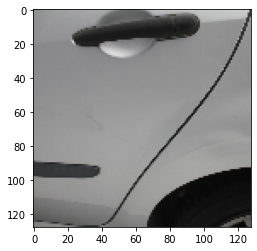

In [202]:
dam = dam_gen.__getitem__(np.random.randint(1,1000))
print(dam.shape)
#plt.figure(figsize=(15,15))
plt.imshow(dam[0])


In [19]:
len(non_dam_gen.map_id)

9894

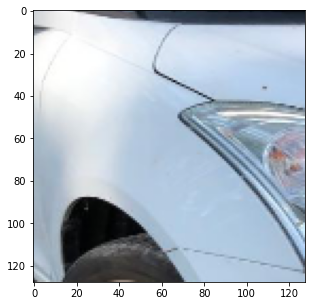

In [195]:
ndam = non_dam_gen.__getitem__(np.random.randint(1,1000))
#print(ndam.shape)
plt.figure(figsize=(5,5))
plt.imshow(ndam[0])


In [56]:
len(dam_gen.map_id)

7941

# MODEL

In [57]:
neighbor_filter=ncut_loss.neighbor_filter((128,128))

In [256]:
encoder = build_Unet.build_Unet(K=18,stages = [1,2,3,4],filters = 64,type='encoder',input_size=128,use_dropout=False)
decoder = build_Unet.build_Unet(K=18,stages = [1,2,3,4],filters = 64,type='decoder',input_size=128,use_dropout=False)
wn = build_Wnet.Wnet(encoder,decoder,(128,128))

def custom_loss(y_true, y_pred):
    return K.mean(y_true - y_pred)**2

# Compile the model
wn.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.003),
    loss_fn_segmentation = ncut_loss.compute_soft_ncuts,
    loss_fn_reconstruction = tf.keras.losses.MeanSquaredError()
)


In [321]:
wn.load_weights("/home/ubuntu/trainings/damages_classification/2021-06-17-Wnet/Wnet18/ckpt800")

In [322]:
def rescale(image):
    return( (((image+1)/2)*255 ).astype("uint8") )

In [324]:
def visualise_seg(image,encoder):
    image = tf.expand_dims(image, 0)
    
    seg = encoder(image)
    ag = tf.math.argmax(seg, axis=-1, output_type=tf.dtypes.int64)
    
    print(image.shape)
    print(wn(image).shape)
    
    
    print(type(image))
    loss = ncut_loss.compute_soft_ncuts(image,seg,neighbor_filter)
    
    
    loss_r = tf.keras.losses.MeanSquaredError()(image,wn(image))
    
    print(loss_r)
    plt.figure(figsize=(10,10))
    res = wn(image).numpy()[0]
    res = rescale(res)

    plt.subplot(1,3,1)
    plt.imshow(image[0])
    plt.subplot(1,3,2)
    plt.imshow(ag[0])
    plt.subplot(1,3,3)
    plt.imshow(res)
    
    print(loss)

(1, 128, 128, 3)
(1, 128, 128, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(0.06507374, shape=(), dtype=float32)
tf.Tensor(9.987904, shape=(), dtype=float32)


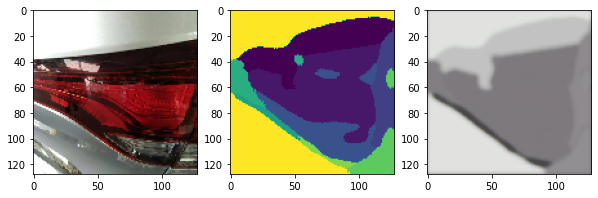

In [325]:
visualise_seg(ndam[0],wn.encoder)


(1, 128, 128, 3)
(1, 128, 128, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(0.033947226, shape=(), dtype=float32)
tf.Tensor(13.045339, shape=(), dtype=float32)


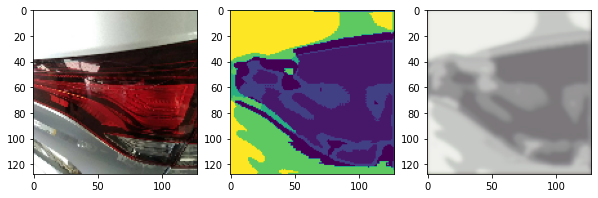

In [310]:
visualise_seg(ndam[0],wn.encoder)


(1, 128, 128, 3)
(1, 128, 128, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(0.034203723, shape=(), dtype=float32)
tf.Tensor(10.879501, shape=(), dtype=float32)


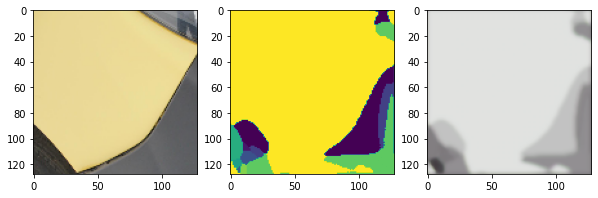

In [326]:
visualise_seg(dam[0],wn.encoder)

(1, 128, 128, 3)
(1, 128, 128, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(0.034203723, shape=(), dtype=float32)
tf.Tensor(10.879501, shape=(), dtype=float32)


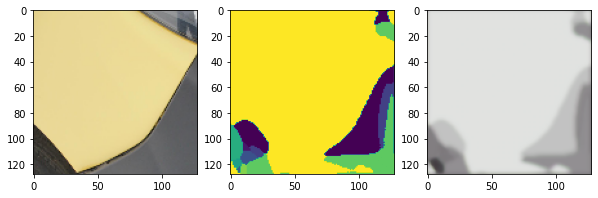

In [327]:
visualise_seg(dam[0],wn.encoder)

In [328]:
dams_reco = []
ndams_reco = []

dams_seg = []
ndams_seg = []

for i in range(0,50):
    ndam = tf.convert_to_tensor(non_dam_gen.__getitem__(i))
    
    dam = tf.convert_to_tensor(dam_gen.__getitem__(i))
    
    seg_dam = wn.encoder(dam)
    seg_ndam = wn.encoder(ndam)
    
    seg_loss_ndam = ncut_loss.compute_soft_ncuts(ndam,seg_ndam,neighbor_filter)
    seg_loss_dam = ncut_loss.compute_soft_ncuts(dam,seg_dam,neighbor_filter)
    
    dams_seg.append(seg_loss_dam.numpy())
    ndams_seg.append(seg_loss_ndam.numpy())
    
    dams_reco.append(tf.keras.losses.MeanSquaredError()(ndam,wn(dam)).numpy())
    ndams_reco.append(tf.keras.losses.MeanSquaredError()(ndam,wn(ndam)).numpy())
    

<AxesSubplot:>

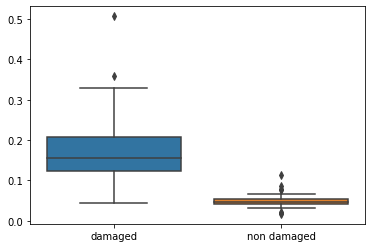

In [329]:
data = {'damaged':dams_reco,'non damaged':ndams_reco}
df = pd.DataFrame(data=data)
sns.boxplot(data=df)

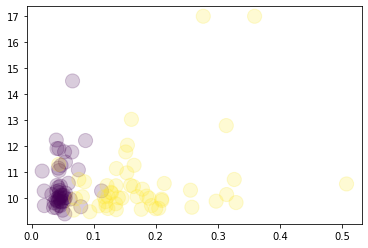

In [330]:
x_plot = ndams_reco+dams_reco
y_plot = dams_seg+ndams_seg
label = [0]*50+[1]*50
plt.scatter(x_plot, y_plot, s=200, c=label,alpha=0.2)

In [331]:
from sklearn.linear_model import LogisticRegression

In [332]:
X_clf=[]

for i in range(len(ndams_reco)):
    X_clf.append([ndams_reco[i],ndams_seg[i]])
for i in range(len(dams_reco)):
    X_clf.append([dams_reco[i],dams_seg[i]])

X_clf = np.array(X_clf)
print(X_clf.shape)



y_clf = [0]*50+[1]*50
clf = LogisticRegression()
clf.fit(np.array(X_clf).reshape(-1,2),np.array(y_clf).reshape(-1, 1))

print(clf.score(X_clf,y_clf))


(100, 2)
0.89


In [333]:
dams_reco_test = []
ndams_reco_test = []

dams_seg_test = []
ndams_seg_test = []

for i in range(500,551):
    ndam = tf.convert_to_tensor(non_dam_gen.__getitem__(i))
    
    dam = tf.convert_to_tensor(dam_gen.__getitem__(i))
    
    seg_dam = wn.encoder(dam)
    seg_ndam = wn.encoder(ndam)
    
    seg_loss_ndam = ncut_loss.compute_soft_ncuts(ndam,seg_ndam,neighbor_filter)
    seg_loss_dam = ncut_loss.compute_soft_ncuts(dam,seg_dam,neighbor_filter)
    
    dams_seg_test.append(seg_loss_dam.numpy())
    ndams_seg_test.append(seg_loss_ndam.numpy())
    
    dams_reco_test.append(tf.keras.losses.MeanSquaredError()(ndam,wn(dam)).numpy())
    ndams_reco_test.append(tf.keras.losses.MeanSquaredError()(ndam,wn(ndam)).numpy())
    

In [334]:
X_test=[]

for i in range(len(ndams_reco_test)):
    X_test.append([ndams_reco_test[i],ndams_seg_test[i]])
for i in range(len(dams_reco_test)):
    X_test.append([dams_reco_test[i],dams_seg_test[i]])

X_test = np.array(X_test)
print(X_test.shape)

(102, 2)


In [335]:
#X_test = np.array([ndams_reco_test+dams_reco_test,ndams_seg_test+dams_seg_test])
y_test = [0]*51+[1]*51

pred = clf.predict(np.array(X_test).reshape(-1,2))

clf.score(np.array(X_test).reshape(-1,2),np.array(y_test).reshape(-1, 1))


0.9313725490196079

In [271]:
#X_test = np.array([ndams_reco_test+dams_reco_test,ndams_seg_test+dams_seg_test])
y_test = [0]*51+[1]*51

pred = clf.predict(np.array(X_test).reshape(-1,2))

clf.score(np.array(X_test).reshape(-1,2),np.array(y_test).reshape(-1, 1))


0.9313725490196079

tf.Tensor(7.663925, shape=(), dtype=float32) 0.049081907


array([0])

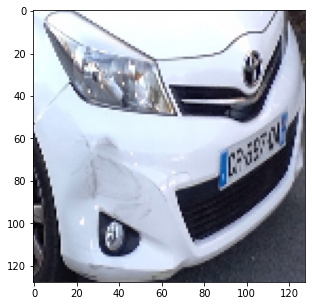

In [291]:
dam = dam_gen.__getitem__(np.random.randint(50,100))
#print(ndam.shape)
plt.figure(figsize=(5,5))
plt.imshow(dam[0])

dam=tf.convert_to_tensor(dam)  
#seg_dam = wn.encoder(dam)
seg_dam = wn.encoder(dam)

#seg_loss_ndam = ncut_loss.compute_soft_ncuts(ndam,seg_ndam,neighbor_filter)


seg_loss_dam = ncut_loss.compute_soft_ncuts(dam,seg_dam,neighbor_filter)
loss_reco = (tf.keras.losses.MeanSquaredError()(dam,wn(dam)).numpy())
print(seg_loss_dam,loss_reco)


clf.predict(np.array([loss_reco,seg_loss_dam]).reshape(1, -1))

In [292]:
from sklearn.metrics import classification_report

In [293]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        51
           1       1.00      0.78      0.88        51

    accuracy                           0.89       102
   macro avg       0.91      0.89      0.89       102
weighted avg       0.91      0.89      0.89       102



In [276]:
len(non_dam_gen)

9894

In [277]:
len(dam_gen)

7941